# Analysis and Visualization of Pedestrian Dynamics Using PedPy

This notebook focuses on plotting and analyzing pedestrian data, including trajectories, density, and speed metrics, using the `pedpy` library. The goal is to provide insights into pedestrian behavior and flow through visual representations and computational analysis.


## Data Extraction and Visualization Functions

This section comprises functions dedicated to extracting pedestrian trajectory data from input files and visualizing various metrics related to pedestrian dynamics. These functions facilitate the analysis of pedestrian behavior, including trajectory plotting, speed profile computation, and density mapping within defined walkable areas.


### Importing Libraries and Modules

The cell imports several essential Python libraries for data analysis and visualization:

- `re`: A module for working with regular expressions.
- `pedpy`: A specialized library for pedestrian dynamics analysis.
- `shapely`: A library for manipulation and analysis of planar geometric objects.
- `pandas`: A powerful data manipulation and analysis library providing data structures and operations for manipulating numerical tables and time series.
- `matplotlib.pyplot`: A module in matplotlib for plotting graphs.

Additionally, it includes imports from `pathlib` for file system path operations, `shapely.Polygon` for creating geometric polygon shapes, and various types from the `typing` module to enhance code readability and maintainability.

From `pedpy`, it specifically imports multiple functions and classes related to the computation and plotting of pedestrian dynamics and trajectories, such as speed profiles, grid cell interactions, and Voronoi polygons.


In [7]:
%matplotlib inline

import re
import pedpy
import shapely
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
from shapely import Polygon
from typing import Collection

from pedpy.column_identifier import DENSITY_COL
from matplotlib.animation import FuncAnimation

from pedpy import (
    compute_speed_profile, SpeedMethod,
    get_grid_cells, compute_grid_cell_polygon_intersection_area,
    compute_individual_voronoi_polygons, compute_individual_speed,
    SpeedCalculation, Cutoff, plot_profiles,
    TrajectoryData, WalkableArea, plot_measurement_setup,
    compute_classic_density, MeasurementArea, compute_voronoi_density,
    plot_voronoi_cells
)

import os

### Setting save path

The next cell contains two variables:
    - `name`: Indicates the name of the run, used for file path construction.
    - `group`: Indicates the folder in which the `name` run is contained. If the `name` run is directly inside the `runs` folder, `group` must be set to empty string. 
    
The full save path will be: *output/runs/{group}/{run}/plots/*

In [8]:
run = 'prova5'
group = 'Andrea'

### Extracting Trajectories Function

This function, `extract_trajectories`, is designed to parse trajectory data from a specified input file and organize it into a usable format for analysis. Here is a breakdown of the process:

1. **Reading the Input File**:
   - The function reads a CSV file where the delimiter is whitespace (`\s+`), skipping lines that start with `#`.
   - The columns are named explicitly (`'id'`, `'frame'`, `'x'`, `'y'`, `'group'`), with only the necessary columns being used.

2. **Grouping Data**:
   - The data is grouped by the `group` column, which represent different groups of pedestrian, allowing separate analysis per group.

3. **Extracting Frame Rate**:
   - The function reads the first line of the file to find a comment indicating the frame rate (`framerate`) of the data, which is essential for time-based analysis in trajectory data.

4. **Creating Trajectory Data Objects**:
   - For each group, a `TrajectoryData` object is created, holding the dataframe for that group and the extracted frame rate.
   - These objects are useful for further processing where time and movement analysis are required.

In [9]:
def extract_trajectories(input_file: Path) -> Collection[TrajectoryData]:
    df = pd.read_csv(
                input_file,
                sep=r"\s+",
                comment="#",
                header=None,
                names=['id', 'frame', 'x', 'y', 'group'],
                usecols=[0, 1, 2, 3, 5],
    )
    groups = df['group'].unique()
    
    dfs = {}
    for group in groups:
        dfs[group] = df.loc[df['group'] == group]
    
    with open(input_file, 'r') as file:
        first_line = file.readline().strip()
    
    match = re.search(r'# framerate: (\d+) fps', first_line)
    if not match:
        raise Exception('fps not found in trajectory file')
    fps = int(match.group(1))
    
    trajectories = []
    for df in dfs.values():
        traj = TrajectoryData(df, fps)
        trajectories.append(traj)
        
    return trajectories

### Function to Plot Trajectories

The `plot_trajectories` function is used to visualize pedestrian trajectories within a defined walkable area, along with optional start and final target areas. Here is a step-by-step overview of its operations:

1. **Setup Plot**:
   - Initializes a single subplot (`ax`) with an equal aspect ratio to ensure proper scaling of the visual elements.
   - Sets the title of the figure using the provided `level_name`.

2. **Plot Walkable Area**:
   - Utilizes the `pedpy.plot_walkable_area` function to draw the walkable area on the subplot.

3. **Plot Final Targets**:
   - Iterates through the `final_targets` list, plotting each target area as a semi-transparent purple polygon.
   - Labels each target with "Target" followed by its index number, placing the text at the centroid of the polygon.

4. **Plot Start Areas**:
   - Iterates through the `start_areas` list, plotting each start area as a semi-transparent blue polygon.
   - Labels each start area with "Start" followed by its index number, placing the text at the centroid of the polygon.

5. **Plot Trajectories**:
   - Iterates through the `trajectories` list, plotting each trajectory with distinct colors and specified plot parameters (e.g., alpha, width).
   - Uses the `plot_measurement_setup` function to handle the detailed plotting of each trajectory.

6. **Show Plot**:
   - Displays the complete plot with all the visual elements using `plt.show()`.

In [10]:
def plot_trajectories(trajectories: Collection[TrajectoryData], walkable_area: WalkableArea, level_name: str, final_targets: list = None, start_areas: list = None) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_aspect("equal")
    # fig.suptitle(f"Trajectory - {level_name}", y=1.05)
    
    # Plot the walkable area
    pedpy.plot_walkable_area(walkable_area=walkable_area, axes=ax)
    
    # Plot the final targets
    if final_targets is not None:
        for idx, exit_poly in enumerate(final_targets):
            x, y = Polygon(exit_poly).exterior.xy
            plt.fill(x, y, alpha=0.3, color="purple")
            centroid = Polygon(exit_poly).centroid
            plt.text(
                centroid.x, 
                centroid.y, 
                f"Target {idx+1}", 
                ha="center",
                va="center", 
                fontsize=8
            )
    
    # Plot the start areas
    if start_areas is not None:
        for idx, dp in enumerate(start_areas):
            dist_poly = Polygon(dp)
            x, y = dist_poly.exterior.xy
            plt.fill(x, y, alpha=0.3, color="blue")
            centroid = dist_poly.centroid
            plt.text(
                centroid.x,
                centroid.y, 
                f"Start {idx+1}", 
                ha="center",
                va="center",
                fontsize=8
            )
    
    # Plot the trajectories
    for traj, color in zip(trajectories, ['#FF0000', '#0000FF', '#00FF00', '#FFFFFF']):
        plot_measurement_setup(
            walkable_area=walkable_area,
            traj=traj,
            traj_color=color,
            traj_alpha=0.5,
            traj_width=1,
        )
    
    path = f'../output/runs/{group}/{run}/plots/{level_name}/'
    os.makedirs(path, exist_ok=True)
    plt.savefig(path + f'trajectories_{run}.png', bbox_inches='tight')
    plt.show()

### Plotting Speed Profiles Function

The `plot_speed_profiles` function visualizes speed profiles of pedestrian data using various methods to calculate speed within specified spatial grids. It's designed to help analyze the dynamics of pedestrian movement within a defined area. Here's how it functions:

1. **Preparation of Individual Pedestrian Data**:
   - Computes individual Voronoi polygons for a specific pedestrian group (`traj_data[0]`) within the walkable area using a specified cutoff radius and quadrant segments.
   - Calculates individual speeds using a particular method (`SpeedCalculation.BORDER_SINGLE_SIDED`) and a defined frame step, indicating the interval between frames used in the speed calculation.

2. **Merging Data for Comprehensive Analysis**:
   - The function merges individual speed data and cutoff polygon data with the trajectory data of the pedestrian group, ensuring all relevant data is aligned for further processing.

3. **Spatial Grid Preparation**:
   - Defines grid cells within the walkable area with a specified grid size to standardize the spatial analysis. 

4. **Filtering and Reshaping Data**:
   - Filters the comprehensive pedestrian data to include only frames within a specified range (`min_frame` to `max_frame`), focusing the analysis on relevant times.
   - Computes intersection areas between the pedestrian data and the spatial grid, reformulating the data for speed profile computation.

5. **Speed Profile Calculation**:
   - Calculates speed profiles using three methods (Voronoi, Arithmetic, and Mean—each) providing a different perspective on pedestrian speed within the grid cells:
     - **Voronoi**: Considers the Voronoi polygon associated with each pedestrian.
     - **Arithmetic**: Computes an average based on individual speeds.
     - **Mean**: Averages speeds across the entire dataset, ignoring individual variations.

6. **Visualization**:
   - Plots the speed profiles on a set of three subplots within a single figure, labeling each subplot according to the method used and setting the speed range for comparison.
   - Displays the plots with a title indicating the specific level or area being analyzed.

In [11]:
def plot_speed_profiles(traj_data: Collection[TrajectoryData], area: WalkableArea, level_name: str, min_frame: int = 250, max_frame: int = 400, grid: float = 0.4, frame: int = 5) -> None:
    individual_cutoff = compute_individual_voronoi_polygons(
        traj_data=traj_data[0],
        walkable_area=area,
        cut_off=Cutoff(radius=0.8, quad_segments=3),
    )

    individual_speed = compute_individual_speed(
        traj_data=traj_data[0],
        frame_step=frame,
        speed_calculation=SpeedCalculation.BORDER_SINGLE_SIDED,
    )

    profile_data = individual_speed.merge(individual_cutoff)
    profile_data = profile_data.merge(traj_data[0].data)

    grid_cells, _, _ = get_grid_cells(
        walkable_area=area, grid_size=grid
    )

    profile_data = profile_data[
        profile_data.frame.between(min_frame, max_frame)
    ]

    grid_cell_intersection_area, resorted_profile_data = compute_grid_cell_polygon_intersection_area(
        data=profile_data, grid_cells=grid_cells
    )

    voronoi_speed_profile = compute_speed_profile(
        data=resorted_profile_data,
        walkable_area=area,
        grid_intersections_area=grid_cell_intersection_area,
        grid_size=grid,
        speed_method=SpeedMethod.VORONOI,
    )

    arithmetic_speed_profile = compute_speed_profile(
        data=resorted_profile_data,
        walkable_area=area,
        grid_intersections_area=grid_cell_intersection_area,
        grid_size=grid,
        speed_method=SpeedMethod.ARITHMETIC,
    )

    mean_speed_profile = compute_speed_profile(
        data=profile_data,
        walkable_area=area,
        grid_size=grid,
        speed_method=SpeedMethod.MEAN,
    )

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))
    fig.suptitle(f"Speed Profile - {level_name}", y=0.98)

    plot_profiles(
        walkable_area=area,
        profiles=voronoi_speed_profile,
        axes=ax0,
        label="v / m/s",
        vmin=0,
        vmax=1.7,
        title="Voronoi",
    )

    plot_profiles(
        walkable_area=area,
        profiles=arithmetic_speed_profile,
        axes=ax1,
        label="v / m/s",
        vmin=0,
        vmax=1.7,
        title="Arithmetic",
    )

    plot_profiles(
        walkable_area=area,
        profiles=mean_speed_profile,
        axes=ax2,
        label="v / m/s",
        vmin=0,
        vmax=1.7,
        title="Mean",
    )

    path = f'../output/runs/{group}/{run}/plots/{level_name}/'
    os.makedirs(path, exist_ok=True)
    plt.savefig(path + f'speed_profiles_{run}.png')
    plt.show()

### Comparative Analysis of Density Estimation Methods

The function plot_density_comparison provides a visual comparison of different density estimation methods across various spatial environments. Here's an overview of its operation:

1. **Figure Setup**:

    A new figure is created with a specified size and a title that reads "Comparison of Different Density Methods". This sets the context for the visual comparison.

2. **Plotting Density Data**:
    
    The function iterates through the levels_data dictionary, where each key represents a level (or method) and each value is a pandas Series containing density data.
    For each level, a plot is created using the corresponding density data. The x-axis represents the frame, and the y-axis represents the density ($\rho$) in units of 1/$m^2$.
    Colors for each level are fetched from the colors dictionary. If a color is not specified for a level, it defaults to blue.

3. **Axis Labels and Grid**:
    
    The x-axis is labeled `Frame` to indicate the time frame of the data.
    The y-axis is labeled $\rho$ / 1/$m^2$ to specify the density units.
    A grid is added to the plot to enhance readability.

4. **Legend**:

    A legend is generated automatically based on the labels provided for each level, making it easy to distinguish between different density estimation methods.

5. **Display**:

    Finally, the function displays the figure, providing a comparative visual representation of pedestrian density over time for each specified method.

In [12]:
def plot_density_comparison(levels_data: dict, colors: dict, level_name: str) -> None:

    fig = plt.figure()
    fig.set_size_inches(6, 6)
    plt.title("Comparison of different density methods")

    for level, data in levels_data.items():
        plt.plot(
            data.index,
            data.values,
            label=level,
            color=colors.get(level, 'blue')  
        )

    plt.xlabel("frame")
    plt.ylabel("$\\rho$ / 1/$m^2$")
    plt.grid()
    plt.legend()
    
    path = f'../output/runs/{group}/{run}/plots/{level_name}/'
    os.makedirs(path, exist_ok=True)
    plt.savefig(path + f'density_{run}.png')
    plt.show()

### Definition of Spatial Regions and Obstacle Handling

In this section, we establish the framework for defining spatial regions within the pedestrian environment, managing obstacles, and implementing cutoff strategies. The functions developed here lay the groundwork for creating walkable areas, delineating obstacles, and applying cutoff parameters to focus analysis on relevant pedestrian dynamics. Through these functionalities, we ensure accurate representation and effective management of spatial features influencing pedestrian movement and behavior.

### Curve-C

This segment focuses specifically on defining spatial regions and managing obstacles within the `Curve-C` area. Here's a breakdown of the components developed for this particular region:


In [22]:
complete_area = Polygon(
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ]
)
obstacles = [
    Polygon(
        [
            (9.999, -6.5),
            (-7, -6.5),
            (-7, 6.5),
            (9.999, 6.5),
            (9.999, 5.5),
            (-6, 5.5),
            (-6, -5.5),
            (9.999, -5.5),
        ]
    ),
]

curve_c_final_target = [
    [(7.3, 6.5), (7.3, 9.999), (9.999, 9.999), (9.999, 6.5)],
]

curve_c_start_area = [
    [(8, -8), (8, -9), (9, -9), (9, -8)],
]

obstacle = shapely.union_all(obstacles)
curve_c_area = pedpy.WalkableArea(shapely.difference(complete_area, obstacle))

curve_c_traj = extract_trajectories(
    Path("../output/pedpy/CurveCBatch.txt")
)

# curve_c_individual = compute_individual_voronoi_polygons(
#     traj_data=curve_c_traj[0],
#     walkable_area=curve_c_area
# )
#
# curve_c_individual_cutoff = compute_individual_voronoi_polygons(
#     traj_data=curve_c_traj[0],
#     walkable_area=curve_c_area,
#     cut_off= Cutoff(radius=1, quad_segments=3),
# )

### Double Door Opposite

This segment focuses specifically on defining spatial regions and managing obstacles within the `Double Door Opposite` area. Here's a breakdown of the components developed for this particular region:

In [ ]:
complete_area = Polygon(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
)
obstacles = [
    Polygon(
        # bottom right barrier
        [
            (9.999, -4.0),
            (6.5, -4.0),
            (6.5, -3.0),
            (9.999, -3.0)
        ]
    ),
    Polygon(
        # bottom left barrier
        [
            (-9.999, -4.0),
            (3.5, -4.0),
            (3.5, -3.0),
            (-9.999, -3.0)
        ]
    ),
    Polygon(
        # top right barrier
        [
            (-9.999, 4.0),
            (-6.5, 4.0),
            (-6.5, 3.0),
            (-9.999, 3.0)
        ]
    ),
    Polygon(
        # top left barrier
        [
            (9.999, 4.0),
            (-3.5, 4.0),
            (-3.5, 3.0),
            (9.999, 3.0)
        ]
    )   
]


double_door_opposite_final_target = [
    [(-9.999, 8), (-9.999, 9.999), (9.999, 9.999), (9.999, 8)],
    [(-9.999, -8), (-9.999, -9.999), (9.999, -9.999), (9.999, -8)]
]

double_door_opposite_start_area = [
    [(1.7, -7.5), (6.1, -7.5), (6.1, -8.5), (1.7, -8.5)],
    [(-1.7, 7.5), (-6.1, 7.5), (-6.1, 8.5), (-1.7, 8.5)]
   
]

obstacle = shapely.union_all(obstacles)
double_door_opposite_area = pedpy.WalkableArea(shapely.difference(complete_area, obstacle))

double_door_opposite_traj = extract_trajectories(
    Path("../output/pedpy/DoubleDoorOppositeBatch.txt")
)

# double_door_opposite_individual = (
#     compute_individual_voronoi_polygons(
#         traj_data=double_door_opposite_traj[0], 
#         walkable_area=double_door_opposite_area
#     )
# )
    

# double_door_opposite_individual_cutoff = (
#     compute_individual_voronoi_polygons(
#         traj_data=double_door_opposite_traj[0], 
#         walkable_area=double_door_opposite_area,
#         cut_off= Cutoff(radius=1, quad_segments=3),
#     )
# )
# 
# double_door_opposite_ma = MeasurementArea(
#      [(4, -2.5), (4, -4.5), (6, -4.5), (6, -2.5)]
# )
#  
# double_door_opposite_classic_density = (
#         compute_classic_density(
#             traj_data=double_door_opposite_traj[0], 
#             measurement_area=double_door_opposite_ma
#         )
# )
# 
# double_door_opposite_density_voronoi, _ = compute_voronoi_density(
#     individual_voronoi_data=double_door_opposite_individual, measurement_area=double_door_opposite_ma
# )
# 
# double_door_opposite_density_voronoi_cutoff, _ = compute_voronoi_density(
#     individual_voronoi_data=double_door_opposite_individual_cutoff, measurement_area=double_door_opposite_ma
# )
# 
# double_door_opposite_data = {
#     "Double Door Opposite Classic": double_door_opposite_classic_density,
#     "Double Door Opposite Voronoi": double_door_opposite_density_voronoi,
#     "Double Door Opposite Voronoi with Cutoff": double_door_opposite_density_voronoi_cutoff,
# }
# 
# double_door_opposite_colors = {
#     "Double Door Opposite Classic": "blue",
#     "Double Door Opposite Voronoi": "orange",
#     "Double Door Opposite Voronoi with Cutoff": "grey",
# }


### Anchor

This segment focuses specifically on defining spatial regions and managing obstacles within the `Anchor` area. Here's a breakdown of the components developed for this particular region:

In [ ]:
complete_area = Polygon(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
)
        
obstacles = [
    Polygon(
         # bottom left barrier
        [
            (-9.999, 3.8),
            (-9.999, 5.8),
            (-3.9, -4.5),
            (-5.1, -4.5),
        ],
    ),
    Polygon(
         #top left anchor
        [
            (-2.0, 2.3),
            (-2.0, 9.999),
            (-3.0, 9.999),
            (-3.0, 4.5),
            (-6.2, 9.999),
            (-7.5, 9.999),
            (-3.0, 2.3),
        ],   
    ),
    Polygon(
        # bottom right barrier
        [
            (9.999, 3.8),
            (9.999, 5.8),
            (3.9, -4.5),
            (5.1, -4.5),
        ],     
    ),
    Polygon(
        #top left anchor
        [
            (2.0, 2.3),
            (2.0, 9.999),
            (3.0, 9.999),
            (3.0, 4.5),
            (6.2, 9.999),
            (7.5, 9.999),
            (3.0, 2.3),
        ],
    ),
    Polygon(
        #bottom barrier
        [
            (-9.999, -4.51),
            (9.999, -4.51),
            (9.999, -5.5),
            (-9.999, -5.5),
        ]
        
    )
]


anchor_final_target = [
    [(-2, 6.7), (-2, 9.999), (2, 9.999), (2, 6.7)]
]

anchor_start_area = [
    [(-7.5, 7), (-7.5, 8), (-8.5, 8), (-8.5, 7)],
    [(-6.5, 3.5), (-5.5, 3.5), (-5.5, 2.5), (-6.5, 2.5)],
    [(7.5, 7), (7.5, 8), (8.5, 8), (8.5, 7)],
    [(6.5, 3.5), (5.5, 3.5), (5.5, 2.5), (6.5, 2.5)],
   
]

obstacle = shapely.union_all(obstacles)
anchor_area = pedpy.WalkableArea(shapely.difference(complete_area, obstacle))

anchor_traj = extract_trajectories(
    Path("../output/pedpy/Anchor8Batch.txt")
)

# anchor_individual = (
#     compute_individual_voronoi_polygons(
#             traj_data=anchor_traj[0], 
#             walkable_area=anchor_area
#     )
# )
# 
# 
# anchor_individual_cutoff = (
#         compute_individual_voronoi_polygons(
#             traj_data=anchor_traj[0], 
#             walkable_area=anchor_area,
#             cut_off= Cutoff(radius=1, quad_segments=3)
#     )
# )
# 
# anchor_ma = MeasurementArea(
#     [(-2, 1), (-2, 3), (2, 3), (2, 1)]
# )
# 
# anchor_classic_density = (
#     compute_classic_density(
#         traj_data=anchor_traj[0], 
#         measurement_area=anchor_ma
#     )
# )
# 
# anchor_density_voronoi, _ = compute_voronoi_density(
#     individual_voronoi_data=anchor_individual, measurement_area=anchor_ma
# )
# 
# anchor_density_voronoi_cutoff, _ = compute_voronoi_density(
#     individual_voronoi_data=anchor_individual_cutoff, measurement_area=anchor_ma
# )

# anchor_data = {
#     "Anchor Classic": anchor_classic_density,
#     "Anchor Voronoi": anchor_density_voronoi,
#     "Anchor Voronoi with Cutoff": anchor_density_voronoi_cutoff,
# }
# 
# anchor_colors = {
#     "Anchor Classic": "blue",
#     "Anchor Voronoi": "orange",
#     "Anchor Voronoi with Cutoff": "grey",
# }

### Omega

This segment focuses specifically on defining spatial regions and managing obstacles within the `Omega` area. Here's a breakdown of the components developed for this particular region:

In [13]:
complete_area = Polygon(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
)
        
obstacles = [
    Polygon(
        # bottom left barrier
        [
            (-6.5, -9.999),
            (-6.5, -3.6),
            (2.45, -3.6),
            (2.45, -9.999),
            (1.45, -9.999),
            (1.45, -4.6),
            (-5.5, -4.6),
            (-5.5, -9.999),
        ]
    ),
    Polygon(
        # mid barrier
        [
            (-9.999, -0.5),
            (6.15, -0.5),
            (6.15, -6.5),
            (7.15, -6.5),
            (7.15, 6.6),
            (6.15, 6.6),
            (-4.0, 0.5),
            (-9.999, 0.5),
        ]  
    ),
    Polygon(
        [
            (-6.5, 9.999),
            (-6.5, 3.8),
            (-5.5, 3.8),
            (4.35, 9.999),
            (2.45, 9.999),
            
        ]
    )
]

omega_final_target = [
    [(-9.999, 6.4), (-9.999, 9.999), (-6.4, 9.999), (-6.4, 6.4)]
]

omega_start_area = [
    [(-8, -8), (-8, -9), (-9, -9), (-9, -8)],   
]

obstacle = shapely.union_all(obstacles)
omega_area = pedpy.WalkableArea(shapely.difference(complete_area, obstacle))

omega_traj = extract_trajectories(
    Path("../output/pedpy/OmegaBatch.txt")
)

# omega_individual = compute_individual_voronoi_polygons(
#     traj_data=omega_traj[0], 
#     walkable_area=omega_area
# )
# 
# omega_individual_cutoff = compute_individual_voronoi_polygons(
#     traj_data=omega_traj[0], 
#     walkable_area=omega_area,
#     cut_off= Cutoff(radius=1, quad_segments=3),
# )

### Door Choice

This segment focuses specifically on defining spatial regions and managing obstacles within the `Door Choice` area. Here's a breakdown of the components developed for this particular region:

In [14]:
complete_area = Polygon(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
)
        
obstacles = [
    Polygon(
        [
            (-9.999, 2.5),
            (-9.999, 3.5),
            (-2.0, 3.5),
            (-2.0, 2.5),
        ]
    ),
    Polygon(
        [
            (9.999, 2.5),
            (9.999, 3.5),
            (2.0, 3.5),
            (2.0, 2.5),
        ] 
    ),
    Polygon(
        [
            (-9.999, -2.5),
            (-9.999, -3.5),
            (-6.0, -3.5),
            (-6.0, -2.5),
        ]
    ),
    Polygon(
        [
            (9.999, -2.5),
            (9.999, -3.5),
            (6.0, -3.5),
            (6.0, -2.5),
        ]
    ),
    Polygon(
        [
            (-2.0, -2.5),
            (-2.0, -3.5),
            (2.0, -3.5),
            (2.0, -2.5),
        ]
    )
]

door_choice_final_target = [
    [(-9.999, 8), (-9.999, 9.999), (9.999, 9.999), (9.999, 8)]
]

door_choice_start_area = [
    [(-8, -5), (-8, -9), (8, -9), (8, -5)],   
]

obstacle = shapely.union_all(obstacles)
door_choice_area = pedpy.WalkableArea(shapely.difference(complete_area, obstacle))

door_choice_traj = extract_trajectories(
    Path("../output/pedpy/DoorChoiceBatch.txt")
)

# door_choice_individual = compute_individual_voronoi_polygons(
#     traj_data=door_choice_traj[0], 
#     walkable_area=door_choice_area
# )
# 
# door_choice_individual_cutoff = compute_individual_voronoi_polygons(
#     traj_data=door_choice_traj[0], 
#     walkable_area=door_choice_area,
#     cut_off= Cutoff(radius=1, quad_segments=3),
# )

### VCross

This segment focuses specifically on defining spatial regions and managing obstacles within the `VCross` area. Here's a breakdown of the components developed for this particular region:

In [15]:
complete_area = Polygon(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
)
        
obstacles = [
    Polygon(
        [
            (-9.999, -5),
            (-9.999, -6),
            (-4.5, -6),
            (-4.5, -5),
            (-9.999, 7),
            (-9.999, 4.5),
            (-5.6, -5),
        ]
    ),
    Polygon(
        [
            (9.999, -5),
            (9.999, -6),
            (4.5, -6),
            (4.5, -5),
            (9.999, 7),
            (9.999, 4.5),
            (5.6, -5),
        ]
    ),
    Polygon(
        [
            (-0.4, -2.5),
            (0.4, -2.5),
            (6.1, 9.999),
            (5, 9.999),
            (0, -1),
            (-5, 9.999),
            (-6.1, 9.999),
        ]
    ),
]

v_cross_final_target = [
    [(-9.999, 7), (-5.7, 9), (-5.2, 8), (-9.5, 5.9)],
    [(9.999, 7), (5.7, 9), (5.2, 8), (9.5, 5.9)],
]

v_cross_start_area = [
    [(9.999, -9.999), (6.5, -9.999), (6.5, -6), (9.999, -6)],   
    [(-9.999, -9.999), (-6.5, -9.999), (-6.5, -6), (-9.999, -6)],   
]

obstacle = shapely.union_all(obstacles)
v_cross_area = pedpy.WalkableArea(shapely.difference(complete_area, obstacle))

v_cross_traj = extract_trajectories(
    Path("../output/pedpy/VCrossBatch.txt")
)

# v_cross_individual = compute_individual_voronoi_polygons(
#     traj_data=door_choice_traj[0], 
#     walkable_area=door_choice_area
# )
# 
# v_cross_individual_cutoff = compute_individual_voronoi_polygons(
#     traj_data=door_choice_traj[0], 
#     walkable_area=door_choice_area,
#     cut_off= Cutoff(radius=1, quad_segments=3),
# )

### Blind Curve

This segment focuses specifically on defining spatial regions and managing obstacles within the `Blind Curve` area. Here's a breakdown of the components developed for this particular region:

In [16]:
complete_area = Polygon(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
)
        
obstacles = [
    Polygon(
        [
            (-4.5, -4),
            (-4.5, -9.999),
            (-5.5, -9.999),
            (-5.5, -4),
        ]
    ),
    Polygon(
        [
            (-9.999, 1),
            (-4.5, 1),
            (-4.5, 9.999),
            (-5.5, 9.999),
            (-5.5, 2),
            (-9.999, 2),
        ]
    ),
    Polygon(
        [
            (0.5, -9.999),
            (1.5, -9.999),
            (1.5, -4),
            (9.999, -4),
            (9.999, -3),
            (0.5, -3),
        ]
    ),
    Polygon(
        [
            (0.5, 9.999),
            (1.5, 9.999),
            (1.5, 2),
            (9.999, 2),
            (9.999, 1),
            (0.5, 1),
        ]
    ),
]

blind_curve_final_target = [
    [(0.5, -9.999), (0.5, -9), (-4.5, -9), (-4.5, -9.999)],
    [(9, -3), (9.999, -3), (9.999, 1), (9, 1)],
]

blind_curve_start_area = [
    [(-4.5, 6), (0.5, 6), (0.5, 9.999), (-4.5, 9.999)],   
    [(-9.999, -9.999), (-5.5, -9.999), (-5.5, -7), (-9.999, -7)],   
]

obstacle = shapely.union_all(obstacles)
blind_curve_area = pedpy.WalkableArea(shapely.difference(complete_area, obstacle))

blind_curve_traj = extract_trajectories(
    Path("../output/pedpy/BlindCurveBatch.txt")
)

# blind_curve_individual = compute_individual_voronoi_polygons(
#     traj_data=door_choice_traj[0], 
#     walkable_area=door_choice_area
# )
# 
# blind_curve_individual_cutoff = compute_individual_voronoi_polygons(
#     traj_data=door_choice_traj[0], 
#     walkable_area=door_choice_area,
#     cut_off= Cutoff(radius=1, quad_segments=3),
# )

## Visualization



### VCross

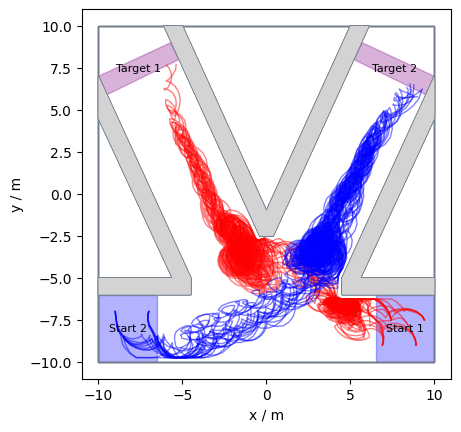

In [17]:
plot_trajectories(v_cross_traj, v_cross_area,"V Cross", v_cross_final_target, v_cross_start_area)

In [18]:
# plot_speed_profiles(v_cross_traj, v_cross_area, "V Cross", 0, 3000)

### Blind Curve

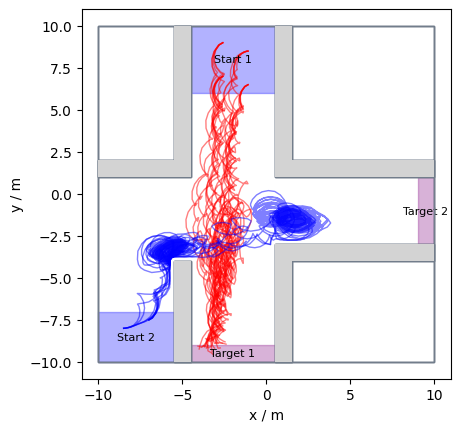

In [19]:
plot_trajectories(blind_curve_traj, blind_curve_area,"Blind Curve", blind_curve_final_target, blind_curve_start_area)

In [20]:
# plot_speed_profiles(blind_curve_traj, blind_curve_area, "Blind Curve", 0, 3000)

### Curve-C

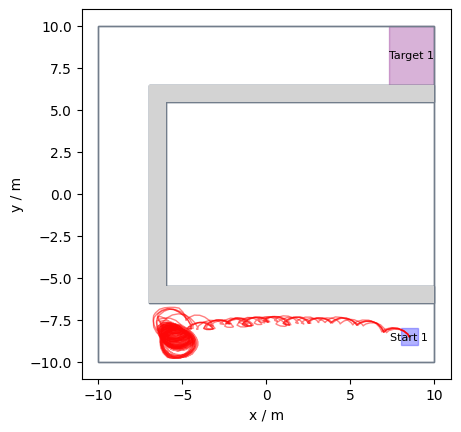

In [23]:
plot_trajectories(curve_c_traj, curve_c_area,"Curve C", curve_c_final_target, curve_c_start_area)

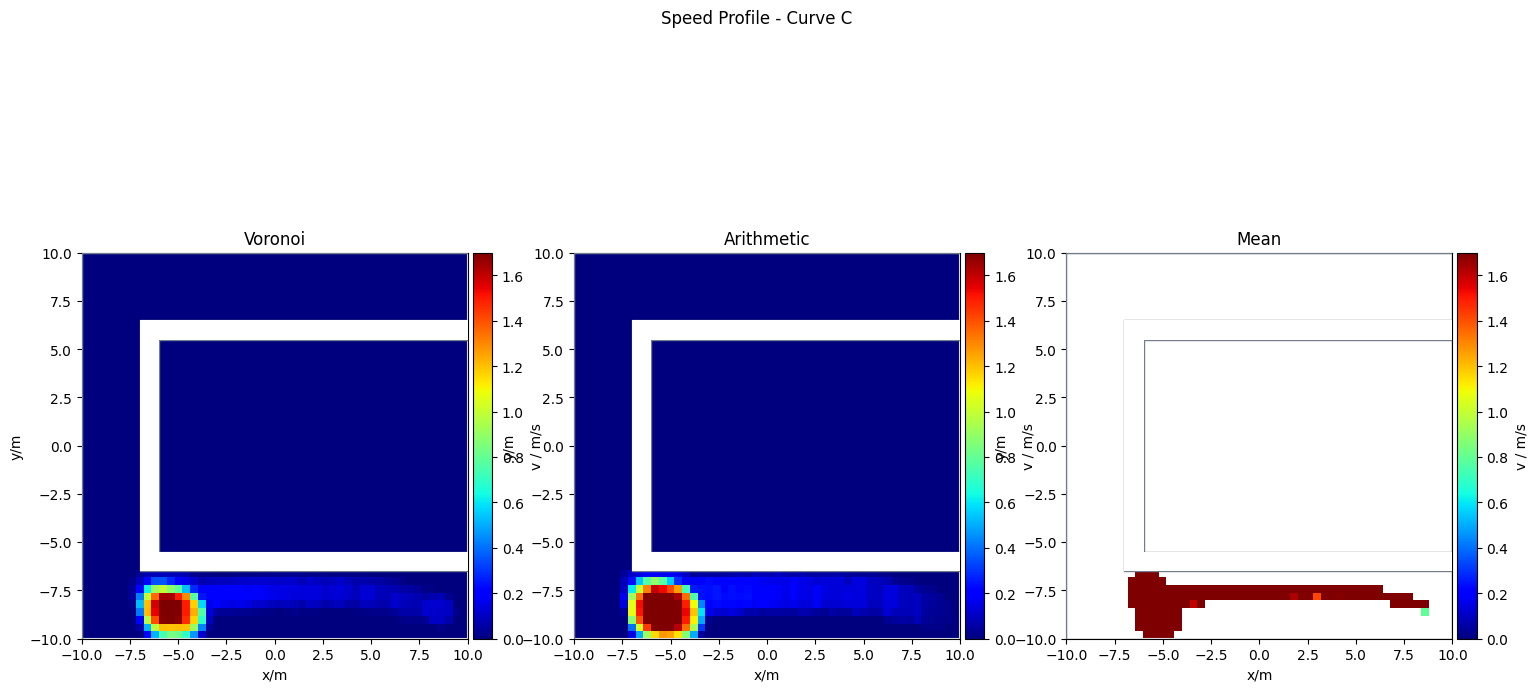

In [24]:
plot_speed_profiles(curve_c_traj, curve_c_area, "Curve C", 0, 3000)

### Double Door Opposite

In [25]:
plot_trajectories(double_door_opposite_traj, double_door_opposite_area, "Double Door Opposite", double_door_opposite_final_target, double_door_opposite_start_area)

NameError: name 'double_door_opposite_traj' is not defined

In [ ]:
# plot_speed_profiles(double_door_opposite_traj, double_door_opposite_area, "Double Door Opposite", 0, 2500)

In [ ]:
# plot_density_comparison(double_door_opposite_data, double_door_opposite_colors, "Double Door Opposite")

### Omega

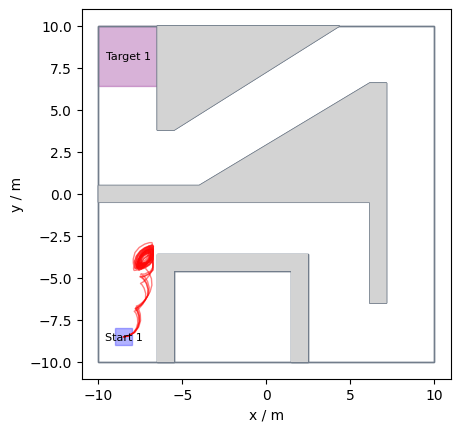

In [26]:
plot_trajectories(omega_traj, omega_area, "Omega", omega_final_target, omega_start_area)

In [27]:
# plot_speed_profiles(omega_traj, omega_area, "Omega", 0, 3500)

### Door Choice

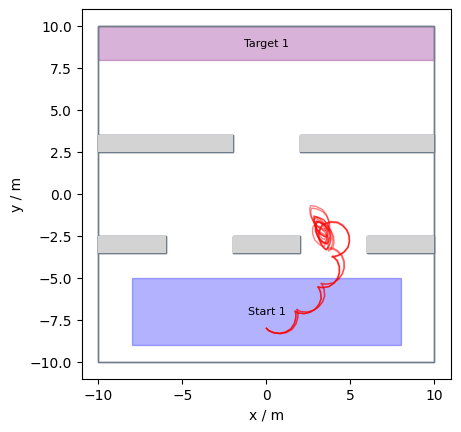

In [28]:
plot_trajectories(door_choice_traj, door_choice_area, "Door Choice", door_choice_final_target, door_choice_start_area)

In [29]:
# plot_speed_profiles(door_choice_traj, door_choice_area, "Door Choice", 0, 1200)

### Anchor

In [ ]:
plot_trajectories(anchor_traj, anchor_area, "Anchor", anchor_final_target, anchor_start_area)

In [ ]:
# plot_speed_profiles(anchor_traj, anchor_area, "Anchor", 0, 1200)

In [ ]:
# plot_density_comparison(anchor_data, anchor_colors, "Anchor")

## Density Animation

### Function to Plot Voronoi Density Animation

The `plot_voronoi_density_animation` function visualizes changes in pedestrian density within a defined walkable area over a series of frames using Voronoi diagrams, comparing results with and without applying a density cutoff. This animated plot provides insights into the dynamic distribution of pedestrian densities over time. Here's a detailed step-by-step overview of its operations:

1. **Initialization**:
   - Enables interactive plotting with `%matplotlib notebook` for dynamic updates.
   - Initializes a figure with two subplots (`ax1` and `ax2`) and a global color bar at the bottom.

2. **Figure and Subplot Configuration**:
   - Sets a title for the figure that incorporates the `level_name`.
   - Each subplot is set up to display different sets of Voronoi diagrams—without cutoff (`ax1`) and with cutoff (`ax2`).

3. **Animation Frame Update Function**:
   - Defines an `update` function to refresh the content of each subplot for each frame in the specified range (`frame_start` to `frame_end` with `step` increments).
   - Clears previous contents to avoid overlap and resets titles to reflect the current frame.

4. **Voronoi Diagram Plotting**:
   - For `ax1`, plots Voronoi cells using the provided `voronoi_data` that visualize density without any cutoff.
   - For `ax2`, uses `voronoi_data_cutoff` to plot Voronoi cells with a density cutoff, focusing on areas with higher pedestrian influence.
   - Both subplots use the same color settings for consistency, defined by the parameters `vmin` and `vmax` to standardize density visualization.

5. **Color Bar Setup**:
   - Adds a horizontal color bar to the figure, which applies to both subplots, showing the density scale from `vmin` to `vmax`.
   - The color bar is labeled to indicate density in units of `1/m^2`, using a gradient color map from green (low density) to yellow (high density).

6. **Animation Configuration**:
   - Creates an animation (`anim`) using `FuncAnimation` that cycles through the specified frames, calling the `update` function for each frame.
   - The animation does not repeat, ending after the last frame is displayed.

7. **Display and Return**:
   - Displays the animated plot, providing a dynamic visualization of changes in pedestrian density over time.
   - Returns the animation object, allowing for further manipulation or saving if required.


In [ ]:
# %matplotlib notebook
# 
# def plot_voronoi_density_animation(voronoi_data, voronoi_data_cutoff, traj_data, walkable_area, frame_start, frame_end, step, level_name: str, vmin: int, vmax: int):
#     frames = list(range(frame_start, frame_end + 1, step))
#     
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
#     fig.suptitle(f"Voronoi Density - {level_name}")
#     
#     def update(frame):
#         ax1.clear()
#         ax2.clear()
#         
#         ax1.set_title(f"Frame {frame} w/o cutoff")
#         ax1.set_aspect('equal')
#         plot_voronoi_cells(
#             voronoi_data=voronoi_data,
#             traj_data=traj_data,
#             frame=frame,
#             walkable_area=walkable_area,
#             color_by_column=DENSITY_COL,
#             axes=ax1,
#             show_colorbar=False,
#             vmin=vmin,
#             vmax=vmax,
#         )
#         
#         ax2.set_title(f"Frame {frame} w/ cutoff")
#         ax2.set_aspect('equal')
#         plot_voronoi_cells(
#             voronoi_data=voronoi_data_cutoff,
#             traj_data=traj_data,
#             frame=frame,
#             walkable_area=walkable_area,
#             color_by_column=DENSITY_COL,
#             axes=ax2,
#             show_colorbar=False,
#             vmin=vmin,
#             vmax=vmax,
#         )
#         
#     cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.03])
#     norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#     sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("YlGn"), norm=norm)
#     sm.set_array([])
#     plt.colorbar(
#         sm,
#         cax=cbar_ax,
#         shrink=0.1,
#         label="$\\rho$ \ 1/$m^2$",
#         aspect=2,
#         orientation="horizontal",
#     )
#     
#     plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.2, hspace=0.35)
# 
#     anim = FuncAnimation(fig, update, frames=frames, repeat=False)
#     plt.show()
#     return anim


In [ ]:
#ddo_anim = plot_voronoi_density_animation( double_door_opposite_individual, double_door_opposite_individual_cutoff, double_door_opposite_traj[0], double_door_opposite_area, 0, 80, 2, "Double Door Opposite", 0, 3)

In [ ]:
#cc_anim = plot_voronoi_density_animation(curve_c_individual, curve_c_individual_cutoff, curve_c_traj[0], curve_c_area, 0, 180, 5, "Curve-C", 0, 1)

In [ ]:
#o_anim = plot_voronoi_density_animation(omega_individual, omega_individual_cutoff, omega_traj[0], omega_area, 0, 150, 5, "Omega", 0, 1)

In [ ]:
#dc_anim = plot_voronoi_density_animation(door_choice_individual, door_choice_individual_cutoff, door_choice_traj[0], door_choice_area, 0, 100, 5, "Door Choice", 0, 1)

In [ ]:
#a_anim = plot_voronoi_density_animation(anchor_individual, anchor_individual_cutoff, anchor_traj[0],anchor_area, 0, 50, 2, "Anchor", 0, 2)